### The flow of the model is as follows->
1. We have trained the VAE with the celebface datatset and obtained the weights of Encoder and Decoder
2. Now we have a taken the Stable Diffusion code and Optimised it according to the below MD-Lite Architecture.
3.We are using the Clip Model to embedd the Prompts of the Images.
4. Flow-> Image-> VAE's trained Encoder-> Z sample-> Forward Diffuison-> Training the UNET model for Denoising -> The obtained Z sample-> VAE's Trained Decoder.

###SelfAttention previous
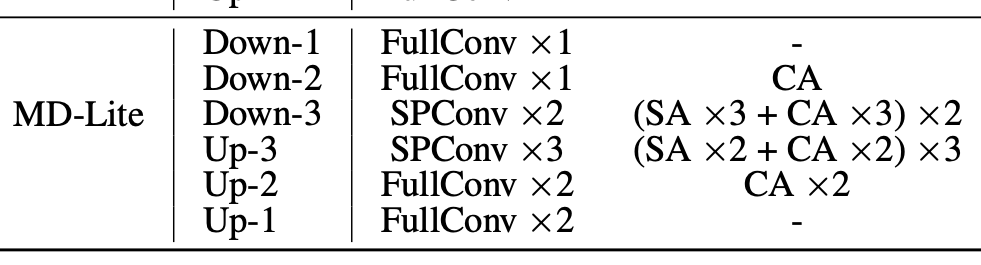

###The Below is the Variational Auto Encoder






In [55]:
# importing necessary libraries
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random

In [56]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = "cpu"

In [57]:
class SelfAttention(nn.Module):
    def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        # This combines the Wq, Wk and Wv matrices into one matrix
        self.in_proj = nn.Linear(d_embed, 3 * d_embed, bias=in_proj_bias)
        # This one represents the Wo matrix
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x, causal_mask=False):
        # x: # (Batch_Size, Seq_Len, Dim)

        # (Batch_Size, Seq_Len, Dim)
        input_shape = x.shape

        # (Batch_Size, Seq_Len, Dim)
        batch_size, sequence_length, d_embed = input_shape

        # (Batch_Size, Seq_Len, H, Dim / H)
        interim_shape = (batch_size, sequence_length, self.n_heads, self.d_head)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim * 3) -> 3 tensor of shape (Batch_Size, Seq_Len, Dim)
        q, k, v = self.in_proj(x).chunk(3, dim=-1)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        # (Batch_Size, H, Seq_Len, Dim / H) @ (Batch_Size, H, Dim / H, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = q @ k.transpose(-1, -2)

        if causal_mask:
            # Mask where the upper triangle (above the principal diagonal) is 1
            mask = torch.ones_like(weight, dtype=torch.bool).triu(1)
            # Fill the upper triangle with -inf
            weight.masked_fill_(mask, -torch.inf)

        # Divide by d_k (Dim / H).
        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight /= math.sqrt(self.d_head)

        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = F.softmax(weight, dim=-1)

        # (Batch_Size, H, Seq_Len, Seq_Len) @ (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        output = weight @ v

        # (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, Seq_Len, H, Dim / H)
        output = output.transpose(1, 2)

        # (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, Seq_Len, Dim)
        output = output.reshape(input_shape)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        output = self.out_proj(output)

        # (Batch_Size, Seq_Len, Dim)
        return output

class CrossAttention(nn.Module):
    def __init__(self, n_heads, d_embed, d_cross, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        self.q_proj   = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
        self.k_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.v_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x, y):
        # x (latent): # (Batch_Size, Seq_Len_Q, Dim_Q)
        # y (context): # (Batch_Size, Seq_Len_KV, Dim_KV) = (Batch_Size, 77, 768)

        input_shape = x.shape
        batch_size, sequence_length, d_embed = input_shape
        # Divide each embedding of Q into multiple heads such that d_heads * n_heads = Dim_Q
        interim_shape = (batch_size, -1, self.n_heads, self.d_head)

        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        q = self.q_proj(x)
        # (Batch_Size, Seq_Len_KV, Dim_KV) -> (Batch_Size, Seq_Len_KV, Dim_Q)
        k = self.k_proj(y)
        # (Batch_Size, Seq_Len_KV, Dim_KV) -> (Batch_Size, Seq_Len_KV, Dim_Q)
        v = self.v_proj(y)

        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_Q, Dim_Q / H)
        q = q.view(interim_shape).transpose(1, 2)
        # (Batch_Size, Seq_Len_KV, Dim_Q) -> (Batch_Size, Seq_Len_KV, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_KV, Dim_Q / H)
        k = k.view(interim_shape).transpose(1, 2)
        # (Batch_Size, Seq_Len_KV, Dim_Q) -> (Batch_Size, Seq_Len_KV, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_KV, Dim_Q / H)
        v = v.view(interim_shape).transpose(1, 2)

        # (Batch_Size, H, Seq_Len_Q, Dim_Q / H) @ (Batch_Size, H, Dim_Q / H, Seq_Len_KV) -> (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight = q @ k.transpose(-1, -2)

        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight /= math.sqrt(self.d_head)

        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight = F.softmax(weight, dim=-1)

        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV) @ (Batch_Size, H, Seq_Len_KV, Dim_Q / H) -> (Batch_Size, H, Seq_Len_Q, Dim_Q / H)
        output = weight @ v

        # (Batch_Size, H, Seq_Len_Q, Dim_Q / H) -> (Batch_Size, Seq_Len_Q, H, Dim_Q / H)
        output = output.transpose(1, 2).contiguous()

        # (Batch_Size, Seq_Len_Q, H, Dim_Q / H) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        output = output.view(input_shape)

        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        output = self.out_proj(output)

        # (Batch_Size, Seq_Len_Q, Dim_Q)
        return output

In [58]:
class VAE_AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32, channels)
        self.attention = SelfAttention(1, channels)

    def forward(self, x):
        # x: (Batch_Size, Features, Height, Width)

        residue = x

        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        x = self.groupnorm(x)

        n, c, h, w = x.shape

        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height * Width)
        x = x.view((n, c, h * w))

        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Height * Width, Features). Each pixel becomes a feature of size "Features", the sequence length is "Height * Width".
        x = x.transpose(-1, -2)

        # Perform self-attention WITHOUT mask
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.attention(x)

        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Features, Height * Width)
        x = x.transpose(-1, -2)

        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Features, Height, Width)
        x = x.view((n, c, h, w))

        # (Batch_Size, Features, Height, Width) + (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        x += residue

        # (Batch_Size, Features, Height, Width)
        return x

In [59]:
import torch
from torch import nn
from torch.nn import functional as F
class VAE_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.groupnorm_1 = nn.GroupNorm(32, in_channels)
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.groupnorm_2 = nn.GroupNorm(32, out_channels)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        # x: (Batch_Size, In_Channels, Height, Width)

        residue = x

        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        x = self.groupnorm_1(x)

        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        x = F.silu(x)

        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = self.conv_1(x)

        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = self.groupnorm_2(x)

        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = F.silu(x)

        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = self.conv_2(x)

        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        return x + self.residual_layer(residue)


In [60]:

import torch
from torch import nn
from torch.nn import functional as F
# from decoder import VAE_AttentionBlock, VAE_ResidualBlock

class VAE_Encoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            # (Batch_Size, Channel, Height, Width) -> (Batch_Size, 128, Height, Width)
            nn.Conv2d(3, 64, kernel_size=3, padding=1),

             # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(64, 64),

            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(64, 64),

            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height / 2, Width / 2)
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=0),

            # (Batch_Size, 128, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(64, 128),

            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(128, 128),

            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 4, Width / 4)
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),

            # (Batch_Size, 256, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(128, 256),

            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(256, 256),

            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0),

            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(256, 256),

            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(256, 256),

            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
#             VAE_ResidualBlock(512, 512),

            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_AttentionBlock(256),

            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(256, 256),

            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.GroupNorm(32, 256),

            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.SiLU(),

            # Because the padding=1, it means the width and height will increase by 2
            # Out_Height = In_Height + Padding_Top + Padding_Bottom
            # Out_Width = In_Width + Padding_Left + Padding_Right
            # Since padding = 1 means Padding_Top = Padding_Bottom = Padding_Left = Padding_Right = 1,
            # Since the Out_Width = In_Width + 2 (same for Out_Height), it will compensate for the Kernel size of 3
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 8, Height / 8, Width / 8).
            nn.Conv2d(256, 8, kernel_size=3, padding=1),

            # (Batch_Size, 8, Height / 8, Width / 8) -> (Batch_Size, 8, Height / 8, Width / 8)
            nn.Conv2d(8, 8, kernel_size=1, padding=0),
        )

    def forward(self, x):
        # x: (Batch_Size, Channel, Height, Width)
        # noise: (Batch_Size, 4, Height / 8, Width / 8)

        for module in self:

            if getattr(module, 'stride', None) == (2, 2):  # Padding at downsampling should be asymmetric (see #8)
                # Pad: (Padding_Left, Padding_Right, Padding_Top, Padding_Bottom).
                # Pad with zeros on the right and bottom.
                # (Batch_Size, Channel, Height, Width) -> (Batch_Size, Channel, Height + Padding_Top + Padding_Bottom, Width + Padding_Left + Padding_Right) = (Batch_Size, Channel, Height + 1, Width + 1)
                x = F.pad(x, (0, 1, 0, 1))

            x = module(x)
        # (Batch_Size, 8, Height / 8, Width / 8) -> two tensors of shape (Batch_Size, 4, Height / 8, Width / 8)
        mean, log_variance = torch.chunk(x, 2, dim=1)
        # Clamp the log variance between -30 and 20, so that the variance is between (circa) 1e-14 and 1e8.
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        log_variance = torch.clamp(log_variance, -30, 20)
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        variance = log_variance.exp()
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        stdev = variance.sqrt().to(DEVICE)
        mean = mean.to(DEVICE)
        # Transform N(0, 1) -> N(mean, stdev)
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        noise = torch.randn(mean.shape).to(DEVICE)
        x = mean + stdev * noise

        # Scale by a constant
        # Constant taken from: https://github.com/CompVis/stable-diffusion/blob/21f890f9da3cfbeaba8e2ac3c425ee9e998d5229/configs/stable-diffusion/v1-inference.yaml#L17C1-L17C1
        x *= 0.18215

        return x, mean, stdev


In [61]:
class VAE_Decoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
            nn.Conv2d(4, 4, kernel_size=1, padding=0),

            # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.Conv2d(4, 256, kernel_size=3, padding=1),

            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(256, 256),

            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_AttentionBlock(256),

            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
#             VAE_ResidualBlock(512, 512),

            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(256, 256),

            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(256, 256),

            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
#             VAE_ResidualBlock(512, 512),

            # Repeats the rows and columns of the data by scale_factor (like when you resize an image by doubling its size).
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 4, Width / 4)
            nn.Upsample(scale_factor=2),

            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            nn.Conv2d(256, 256, kernel_size=3, padding=1),

            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(256, 256),

            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(256, 256),

            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
#             VAE_ResidualBlock(512, 512),

            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 2, Width / 2)
            nn.Upsample(scale_factor=2),

            # (Batch_Size, 512, Height / 2, Width / 2) -> (Batch_Size, 512, Height / 2, Width / 2)
            nn.Conv2d(256, 256, kernel_size=3, padding=1),

            # (Batch_Size, 512, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(256, 128),

            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(128, 128),

            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(128, 128),

            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height, Width)
            nn.Upsample(scale_factor=2),

            # (Batch_Size, 256, Height, Width) -> (Batch_Size, 256, Height, Width)
            nn.Conv2d(128, 128, kernel_size=3, padding=1),

            # (Batch_Size, 256, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(128, 64),

            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(64, 64),

            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(64, 64),

            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            nn.GroupNorm(32, 64),

            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            nn.SiLU(),

            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 3, Height, Width)
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
        )

    def forward(self, x):
        # x: (Batch_Size, 4, Height / 8, Width / 8)

        # Remove the scaling added by the Encoder.
        x /= 0.18215

        for module in self:
            x = module(x)

        # (Batch_Size, 3, Height, Width)
        return x

In [62]:
from torchvision import transforms
def get_image(img_path):

        image = Image.open(img_path).convert("RGB")
        transform = transforms.Compose(
            [
                transforms.Resize(128),
                transforms.ToTensor(),
                transforms.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
            ]
        )
        image = transform(image)
        return image

###Checking the Z_sample by using an image

In [63]:
# Assuming VAE_Decoder is your class, first instantiate it
encoder = VAE_Encoder()

# Load the state dictionary from the file
state_dict = torch.load('/content/vae_encoder_0.003.pth')
# ,map_location=torch.device('cpu')

# Now load the state dictionary into your model instance
encoder.load_state_dict(state_dict)

# Now your decoder model has the trained weights loaded and is ready to be used


<All keys matched successfully>

In [10]:
import math

In [64]:
# Sample a latent vector z from a standard normal distribution
z_sample = get_image("/content/4.jpg")
# encoder(z_sample)
# z_sample = torch.randn(1,3,128,128)  # batch_size can be 1 or more depending on your need
# # Assuming 'decoder' is an instance of VAE_Decoder
# x_recon,_,_ = encoder(z_sample)
# print(x_recon)
import torch

# Assuming z_sample is a PyTorch tensor with shape (3, 128, 128)
z_sample = z_sample.unsqueeze(0)  # Adds a new dimension at the 0th index

# Now, z_sample has a shape of (1, 3, 128, 128)
print(f"New shape with batch size: {z_sample.shape}")

# print(z_sample.shape)
x_recon,_,_ = encoder(z_sample)
print(x_recon.shape)

New shape with batch size: torch.Size([1, 3, 128, 128])
torch.Size([1, 4, 16, 16])


In [65]:
decoder = VAE_Decoder()

# Load the state dictionary from the file
state_dict_1 = torch.load('/content/vae_decoder_0.003.pth')

# Now load the state dictionary into your model instance
decoder.load_state_dict(state_dict_1)


<All keys matched successfully>

In [ ]:
# # np.count_nonzero(x_recon<0), np.count_nonzero(x_recon>1)
# # Assuming x_recon is a PyTorch tensor on the GPU
# x_recon_cpu = x_recon.cpu()  # Move tensor to CPU
# x_recon_numpy = x_recon_cpu.detach().numpy()  # Convert to NumPy array

# # Now you can perform your NumPy operations
# count_negative = np.count_nonzero(x_recon_numpy < -1)
# count_above_one = np.count_nonzero(x_recon_numpy > 1)

# print(f"Count of negative values: {count_negative}")
# print(f"Count of values above one: {count_above_one}")


Count of negative values: 0
Count of values above one: 0


###Clip model for Embedding the Captions



In [67]:
import torch
from torch import nn
from torch.nn import functional as F
from transformers import CLIPTokenizer

In [68]:
class SelfAttention(nn.Module):
    def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        # This combines the Wq, Wk and Wv matrices into one matrix
        self.in_proj = nn.Linear(d_embed, 3 * d_embed, bias=in_proj_bias)
        # This one represents the Wo matrix
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x, causal_mask=False):
        # x: # (Batch_Size, Seq_Len, Dim)

        # (Batch_Size, Seq_Len, Dim)
        input_shape = x.shape

        # (Batch_Size, Seq_Len, Dim)
        batch_size, sequence_length, d_embed = input_shape

        # (Batch_Size, Seq_Len, H, Dim / H)
        interim_shape = (batch_size, sequence_length, self.n_heads, self.d_head)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim * 3) -> 3 tensor of shape (Batch_Size, Seq_Len, Dim)
        q, k, v = self.in_proj(x).chunk(3, dim=-1)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        # (Batch_Size, H, Seq_Len, Dim / H) @ (Batch_Size, H, Dim / H, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = q @ k.transpose(-1, -2)

        if causal_mask:
            # Mask where the upper triangle (above the principal diagonal) is 1
            mask = torch.ones_like(weight, dtype=torch.bool).triu(1)
            # Fill the upper triangle with -inf
            weight.masked_fill_(mask, -torch.inf)

        # Divide by d_k (Dim / H).
        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight /= math.sqrt(self.d_head)

        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = F.softmax(weight, dim=-1)

        # (Batch_Size, H, Seq_Len, Seq_Len) @ (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        output = weight @ v

        # (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, Seq_Len, H, Dim / H)
        output = output.transpose(1, 2)

        # (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, Seq_Len, Dim)
        output = output.reshape(input_shape)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        output = self.out_proj(output)

        # (Batch_Size, Seq_Len, Dim)
        return output


In [69]:
import torch
from torch import nn
from torch.nn import functional as F

class CLIPEmbedding(nn.Module):
    def __init__(self, n_vocab: int, n_embd: int, n_token: int):
        super().__init__()

        self.token_embedding = nn.Embedding(n_vocab, n_embd)
        # A learnable weight matrix encodes the position information for each token
        self.position_embedding = nn.Parameter(torch.zeros((n_token, n_embd)))

    def forward(self, tokens):
        # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
        x = self.token_embedding(tokens)

        # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
        x += self.position_embedding

        return x

class CLIPLayer(nn.Module):
    def __init__(self, n_head: int, n_embd: int):
        super().__init__()

        # Pre-attention norm
        self.layernorm_1 = nn.LayerNorm(n_embd)
        # Self attention
        self.attention = SelfAttention(n_head, n_embd)
        # Pre-FNN norm
        self.layernorm_2 = nn.LayerNorm(n_embd)
        # Feedforward layer
        self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
        self.linear_2 = nn.Linear(4 * n_embd, n_embd)

    def forward(self, x):
        # (Batch_Size, Seq_Len, Dim)
        residue = x

        ### SELF ATTENTION ###

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.layernorm_1(x)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.attention(x, causal_mask=True)

        # (Batch_Size, Seq_Len, Dim) + (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x += residue

        ### FEEDFORWARD LAYER ###
        # Apply a feedforward layer where the hidden dimension is 4 times the embedding dimension.

        residue = x
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.layernorm_2(x)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, 4 * Dim)
        x = self.linear_1(x)

        # (Batch_Size, Seq_Len, 4 * Dim) -> (Batch_Size, Seq_Len, 4 * Dim)
        x = x * torch.sigmoid(1.702 * x)   # QuickGELU activation function

        # (Batch_Size, Seq_Len, 4 * Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.linear_2(x)

        # (Batch_Size, Seq_Len, Dim) + (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x += residue

        return x

class CLIP(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = CLIPEmbedding(49408, 768, 77)

        self.layers = nn.ModuleList([
            CLIPLayer(12, 768) for i in range(12)
        ])

        self.layernorm = nn.LayerNorm(768)

    def forward(self, tokens: torch.LongTensor) -> torch.FloatTensor:
        tokens = tokens.type(torch.long)

        # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
        state = self.embedding(tokens)

        # Apply encoder layers similar to the Transformer's encoder.
        for layer in self.layers:
            # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
            state = layer(state)
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        output = self.layernorm(state)

        return output

In [70]:
import torch
import torch.nn as nn
from transformers import CLIPTokenizer
# from CLIP import CLIP  # Make sure you have a proper import for your CLIP model

class TextEmbeddingProcessor(nn.Module):
    def __init__(self, device):
        super(TextEmbeddingProcessor, self).__init__()
        self.device = device  # Store the device as an instance variable
        self.clip = CLIP()  # Assuming CLIP() is a defined model compatible with these inputs
        self.clip.to(self.device)  # Move the CLIP model to the specified device
        self.tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
        self.text_emb_layer = nn.Linear(59136, 4 * 16 * 16).to(self.device)  # Move the linear layer to the device

    def forward(self, prompt, uncond_prompt="", do_cfg=True, cfg_scale=8):
        if do_cfg:
            # Conditional tokens
            cond_tokens = self.tokenizer(prompt, padding="max_length", truncation=True, max_length=77, return_tensors="pt").input_ids.to(self.device)
            cond_context = self.clip(cond_tokens)

            # # Unconditional tokens
            # uncond_tokens = self.tokenizer(uncond_prompt, padding="max_length", truncation=True, max_length=77, return_tensors="pt").input_ids.to(self.device)
            # uncond_context = self.clip(uncond_tokens)

            # Concatenate contexts
            # context = torch.cat([cond_context, cond_context], dim=0)
            context = cond_context
        else:
            # Handle case where CFG is not used
            tokens = self.tokenizer(prompt, padding="max_length", truncation=True, max_length=77, return_tensors="pt").input_ids.to(self.device)
            context = self.clip(tokens)

        # Reshape and transform context
        x, y, z = context.shape
        text_emb_flat = context.view(x, y * z)  # Flatten context
        text_emb_transformed = self.text_emb_layer(text_emb_flat)
        text_emb_reshaped = text_emb_transformed.view(-1, 4, 16, 16)  # Reshape to target dimensions; ensure batch size handling with -1
        text_emb_reshaped = torch.clamp(text_emb_reshaped, -1, 1)  # Clamp values to range [-1, 1]

        return text_emb_reshaped




torch.Size([1, 4, 16, 16])


In [71]:
# Usage example:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = TextEmbeddingProcessor(device=device)
prompt = "A teenage boy wearing a blue shirt."
output = processor(prompt)
print(output.shape)  # Should print (2, 4, 16, 16)

torch.Size([1, 4, 16, 16])


###This is the class used to reshape the embeddings so that they fit the concatenation with the Z_sample which will then be denoised


In [30]:
class ReshapeEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(59136, 4*16*16)

    def forward(self, text_emb):
        x, y, z = text_emb.shape
        text_emb_flat = text_emb.view(x,y*z )  # Reshape to include a spatial dimension as if it's a grayscale image
        text_emb_transformed = self.fc(text_emb_flat)
        text_emb_reshaped = text_emb_transformed.view(2, 4, 16, 16)
        text_emb_reshaped = torch.clamp(text_emb_reshaped, -1, 1)
        return text_emb_reshaped

# # Create the module and apply
# reshape_module = ReshapeEmbedding()
# text_emb = torch.randn(2, 77, 768)
# text_emb_reshaped = reshape_module(text_emb)
# text_emb_reshaped.shape, np.count_nonzero(text_emb_reshaped.cpu().detach().numpy()<-1), np.count_nonzero(text_emb_reshaped.cpu().detach().numpy()>1)

In [ ]:
print(text_emb_reshaped.shape)

torch.Size([2, 4, 16, 16])


In [17]:
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.0 MB/s eta 0:00:00


###This is also a model which can be used for denoising that is -> UNET2Dmodel

In [72]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from torchvision import datasets, transforms
import torch.utils.data as data_utils
import json

In [ ]:
transform = transforms.Compose([transforms.Resize([128,128]),
                                 transforms.ToTensor()])
train_dataset = datasets.ImageFolder('/kaggle/input/animals-class/raw-img/', transform=transform)

# indices = torch.arange(100)
# train_dataset = data_utils.Subset(train_dataset, indices)

print("Length of dataset", len(train_dataset))

print("Dataset Loaded")

# with open("label_animal.json", "w") as outfile:
#     json.dump(train_dataset.class_to_idx, outfile)


In [75]:

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')





class ClassConditionedUnet(nn.Module):
  def __init__(self,device = None, num_classes=10, class_emb_size=4):
    super().__init__()

    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = TextEmbeddingProcessor(device)



    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=256,           # the target image resolution
        in_channels=4 + class_emb_size, # Additional input channels for class cond.
        out_channels=4,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    # Shape of x:
    bs, ch, w, h = x.shape
    print(x.shape)

    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dimension
    print(class_cond.size())
    # class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, class_cond), 1)# (bs, 5, 28, 28)
    print(net_input.size())

    # Feed this to the UNet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)


Using device: cuda:0


In [ ]:

# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=10, beta_schedule='squaredcos_cap_v2')

# Training loop (10 Epochs):

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Epochs
n_epochs = 3

# Our network
net = ClassConditionedUnet().to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):

        # Get some data and prepare the corrupted version
        x = x.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 9, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_x, timesteps, y) # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')


torch.save(net.state_dict(), "model_animal.pt")

NameError: name 'train_dataset' is not defined

###The MDLite model as described in the Mobile Diffusion Paper -> [Mobile Diffusion
](https://research.google/blog/mobilediffusion-rapid-text-to-image-generation-on-device/)

In [89]:
import torch
from torch import nn
from torch.nn import functional as F
import math


class UnetSelfAttention(nn.Module):
    def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        # This combines the Wq, Wk and Wv matrices into one matrix
        self.in_proj = nn.Linear(d_embed, 2 * d_embed, bias=in_proj_bias)
        # This one represents the Wo matrix
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x, causal_mask=False):
        # x: # (Batch_Size, Seq_Len, Dim)

        # (Batch_Size, Seq_Len, Dim)
        input_shape = x.shape

        # (Batch_Size, Seq_Len, Dim)
        batch_size, sequence_length, d_embed = input_shape

        # (Batch_Size, Seq_Len, H, Dim / H)
        interim_shape = (batch_size, sequence_length, self.n_heads, self.d_head)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim * 3) -> 3 tensor of shape (Batch_Size, Seq_Len, Dim)
        q, k = self.in_proj(x).chunk(2, dim=-1)
        v = k

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        # (Batch_Size, H, Seq_Len, Dim / H) @ (Batch_Size, H, Dim / H, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = q @ k.transpose(-1, -2)

        if causal_mask:
            # Mask where the upper triangle (above the principal diagonal) is 1
            mask = torch.ones_like(weight, dtype=torch.bool).triu(1)
            # Fill the upper triangle with -inf
            weight.masked_fill_(mask, -torch.inf)

        # Divide by d_k (Dim / H).
        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight /= math.sqrt(self.d_head)

        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        relu = nn.ReLU()
        weight = relu(weight)

        # (Batch_Size, H, Seq_Len, Seq_Len) @ (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        output = weight @ v

        # (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, Seq_Len, H, Dim / H)
        output = output.transpose(1, 2)

        # (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, Seq_Len, Dim)
        output = output.reshape(input_shape)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        output = self.out_proj(output)

        # (Batch_Size, Seq_Len, Dim)
        return output

class UnetCrossAttention(nn.Module):
    def __init__(self, n_heads, d_embed, d_cross, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        self.q_proj   = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
        self.k_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.v_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x, y):
        # x (latent): # (Batch_Size, Seq_Len_Q, Dim_Q)
        # y (context): # (Batch_Size, Seq_Len_KV, Dim_KV) = (Batch_Size, 77, 768)

        input_shape = x.shape
        batch_size, sequence_length, d_embed = input_shape
        # Divide each embedding of Q into multiple heads such that d_heads * n_heads = Dim_Q
        interim_shape = (batch_size, -1, self.n_heads, self.d_head)

        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        print("x in cross attention",x.shape)
        q = self.q_proj(x)
        # (Batch_Size, Seq_Len_KV, Dim_KV) -> (Batch_Size, Seq_Len_KV, Dim_Q)
        k = self.k_proj(y)
        # (Batch_Size, Seq_Len_KV, Dim_KV) -> (Batch_Size, Seq_Len_KV, Dim_Q)
        v = self.v_proj(y)
        # v = k
        print("printing q,k,v",q.shape, k.shape, v.shape)

        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_Q, Dim_Q / H)
        q = q.view(interim_shape).transpose(1, 2)
        # (Batch_Size, Seq_Len_KV, Dim_Q) -> (Batch_Size, Seq_Len_KV, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_KV, Dim_Q / H)
        k = k.view(interim_shape).transpose(1, 2)
        # (Batch_Size, Seq_Len_KV, Dim_Q) -> (Batch_Size, Seq_Len_KV, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_KV, Dim_Q / H)
        v = v.view(interim_shape).transpose(1, 2)

        # (Batch_Size, H, Seq_Len_Q, Dim_Q / H) @ (Batch_Size, H, Dim_Q / H, Seq_Len_KV) -> (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight = q @ k.transpose(-1, -2)

        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight /= math.sqrt(self.d_head)

        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        relu = nn.ReLU()
        weight = relu(weight)

        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV) @ (Batch_Size, H, Seq_Len_KV, Dim_Q / H) -> (Batch_Size, H, Seq_Len_Q, Dim_Q / H)
        output = weight @ v

        # (Batch_Size, H, Seq_Len_Q, Dim_Q / H) -> (Batch_Size, Seq_Len_Q, H, Dim_Q / H)
        output = output.transpose(1, 2).contiguous()

        # (Batch_Size, Seq_Len_Q, H, Dim_Q / H) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        output = output.view(input_shape)

        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        output = self.out_proj(output)

        # (Batch_Size, Seq_Len_Q, Dim_Q)
        return output
import torch
from torch import nn
from torch.nn import functional as F
# from attention import SelfAttention, CrossAttention

class TimeEmbedding(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
        self.linear_2 = nn.Linear(4 * n_embd, 4 * n_embd)

    def forward(self, x):
        # x: (1, 320)

        # (1, 320) -> (1, 1280)
        x = self.linear_1(x)

        # (1, 1280) -> (1, 1280)
        x = F.silu(x)

        # (1, 1280) -> (1, 1280)
        x = self.linear_2(x)

        return x
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # x: (Batch_Size, In_Channels, Height, Width)

        # Depthwise convolution
        x = self.depthwise(x)

        # Pointwise convolution (1x1 kernel)
        x = self.pointwise(x)

        return x

class UNET_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_time=1280):
        super().__init__()
        self.groupnorm_feature = nn.GroupNorm(32, in_channels)
        self.conv_feature = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.linear_time = nn.Linear(n_time, out_channels)

        self.groupnorm_merged = nn.GroupNorm(32, out_channels)
        self.conv_merged = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

    def forward(self, feature, time):
        # feature: (Batch_Size, In_Channels, Height, Width)
        # time: (1, 1280)

        residue = feature

        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        feature = self.groupnorm_feature(feature)

        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        feature = F.silu(feature)

        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        feature = self.conv_feature(feature)

        # (1, 1280) -> (1, 1280)
        time = F.silu(time)

        # (1, 1280) -> (1, Out_Channels)
        time = self.linear_time(time)

        # Add width and height dimension to time.
        # (Batch_Size, Out_Channels, Height, Width) + (1, Out_Channels, 1, 1) -> (Batch_Size, Out_Channels, Height, Width)
        merged = feature + time.unsqueeze(-1).unsqueeze(-1)

        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        merged = self.groupnorm_merged(merged)

        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        merged = F.silu(merged)

        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        merged = self.conv_merged(merged)

        # (Batch_Size, Out_Channels, Height, Width) + (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        return merged + self.residual_layer(residue)

class UNET_Separable_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_time=1280):
        super().__init__()
        self.groupnorm_feature = nn.GroupNorm(32, in_channels)
        self.conv_feature = SeparableConv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.linear_time = nn.Linear(n_time, out_channels)

        self.groupnorm_merged = nn.GroupNorm(32, out_channels)
        self.conv_merged = SeparableConv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = SeparableConv2d(in_channels, out_channels, kernel_size=1, padding=0)

    def forward(self, feature, time):
        # feature: (Batch_Size, In_Channels, Height, Width)
        # time: (1, 1280)

        residue = feature

        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        feature = self.groupnorm_feature(feature)

        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        feature = F.silu(feature)

        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        feature = self.conv_feature(feature)
        print("d")

        # (1, 1280) -> (1, 1280)
        time = F.silu(time)
        # assert isinstance(timesteps, torch.Tensor)


        # (1, 1280) -> (1, Out_Channels)
        time = self.linear_time(time)

        # Add width and height dimension to time.
        # (Batch_Size, Out_Channels, Height, Width) + (1, Out_Channels, 1, 1) -> (Batch_Size, Out_Channels, Height, Width)
        merged = feature + time.unsqueeze(-1).unsqueeze(-1)

        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        merged = self.groupnorm_merged(merged)

        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        merged = F.silu(merged)

        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        merged = self.conv_merged(merged)

        # (Batch_Size, Out_Channels, Height, Width) + (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        return merged + self.residual_layer(residue)


class UNET_AttentionBlock(nn.Module):
    def __init__(self, n_head: int, n_embd: int, d_context=768):
        super().__init__()
        channels = n_head * n_embd

        self.groupnorm = nn.GroupNorm(32, channels, eps=1e-6)
        self.conv_input = nn.Conv2d(channels, channels, kernel_size=1, padding=0)

        self.layernorm_1 = nn.LayerNorm(channels)
        self.attention_1 = UnetSelfAttention(n_head, channels, in_proj_bias=False)
        self.layernorm_2 = nn.LayerNorm(channels)
        self.attention_2 = UnetCrossAttention(n_head, channels, d_context, in_proj_bias=False)
        self.layernorm_3 = nn.LayerNorm(channels)
        self.linear_geglu_1  = nn.Linear(channels, 4 * channels * 2)
        self.linear_geglu_2 = nn.Linear(4 * channels, channels)

        self.conv_output = nn.Conv2d(channels, channels, kernel_size=1, padding=0)

    def forward(self, x, context):
        # x: (Batch_Size, Features, Height, Width)
        # context: (Batch_Size, Seq_Len, Dim)

        residue_long = x

        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        x = self.groupnorm(x)

        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        x = self.conv_input(x)

        n, c, h, w = x.shape

        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height * Width)
        x = x.view((n, c, h * w))

        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Height * Width, Features)
        x = x.transpose(-1, -2)

        # Normalization + Self-Attention with skip connection

        # (Batch_Size, Height * Width, Features)
        residue_short = x

        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.layernorm_1(x)

        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.attention_1(x)

        # (Batch_Size, Height * Width, Features) + (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x += residue_short

        # (Batch_Size, Height * Width, Features)
        residue_short = x

        # Normalization + Cross-Attention with skip connection

        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.layernorm_2(x)

        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.attention_2(x, context)

        # (Batch_Size, Height * Width, Features) + (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x += residue_short

        # (Batch_Size, Height * Width, Features)
        residue_short = x

        # Normalization + FFN with GeGLU and skip connection

        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.layernorm_3(x)

        # GeGLU as implemented in the original code: https://github.com/CompVis/stable-diffusion/blob/21f890f9da3cfbeaba8e2ac3c425ee9e998d5229/ldm/modules/attention.py#L37C10-L37C10
        # (Batch_Size, Height * Width, Features) -> two tensors of shape (Batch_Size, Height * Width, Features * 4)
        x, gate = self.linear_geglu_1(x).chunk(2, dim=-1)

        # Element-wise product: (Batch_Size, Height * Width, Features * 4) * (Batch_Size, Height * Width, Features * 4) -> (Batch_Size, Height * Width, Features * 4)
        x = x * F.gelu(gate)

        # (Batch_Size, Height * Width, Features * 4) -> (Batch_Size, Height * Width, Features)
        x = self.linear_geglu_2(x)

        # (Batch_Size, Height * Width, Features) + (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x += residue_short

        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Features, Height * Width)
        x = x.transpose(-1, -2)

        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Features, Height, Width)
        x = x.view((n, c, h, w))

        # Final skip connection between initial input and output of the block
        # (Batch_Size, Features, Height, Width) + (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        return self.conv_output(x) + residue_long

class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height * 2, Width * 2)
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return self.conv(x)

class SwitchSequential(nn.Sequential):
    def forward(self, x, context, time):
        for layer in self:
            if isinstance(layer, UNET_AttentionBlock):
                x = layer(x, context)
            # elif isinstance(layer, UNET_Cross_AttentionBlock):
                # x = layer(x, context)
            elif isinstance(layer, UNET_ResidualBlock):
                x = layer(x, time)
            elif isinstance(layer, UNET_Separable_ResidualBlock):
                x = layer(x, time)
            else:
                x = layer(x)
        return x

# class UNET(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.encoders = nn.ModuleList([
#             # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8)
#             SwitchSequential(nn.Conv2d(4, 320, kernel_size=3, padding=1)),

#             # (Batch_Size, 320, Height / 8, Width / 8) -> # (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8)
#             SwitchSequential(UNET_ResidualBlock(320, 320), UNET_Cross_AttentionBlock(8, 40)),

#             # (Batch_Size, 320, Height / 8, Width / 8) -> # (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8)
#             SwitchSequential(UNET_ResidualBlock(320, 320), UNET_AttentionBlock(8, 40)),

#             # (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 16, Width / 16)
#             SwitchSequential(nn.Conv2d(320, 320, kernel_size=3, stride=2, padding=1)),

#             # (Batch_Size, 320, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16)
#             SwitchSequential(UNET_ResidualBlock(320, 640), UNET_AttentionBlock(8, 80)),

#             # (Batch_Size, 640, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16)
#             SwitchSequential(UNET_ResidualBlock(640, 640), UNET_AttentionBlock(8, 80)),

#             # (Batch_Size, 640, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 32, Width / 32)
#             SwitchSequential(nn.Conv2d(640, 640, kernel_size=3, stride=2, padding=1)),

#             # (Batch_Size, 640, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32)
#             SwitchSequential(UNET_ResidualBlock(640, 1280), UNET_AttentionBlock(8, 160)),

#             # (Batch_Size, 1280, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32)
#             SwitchSequential(UNET_ResidualBlock(1280, 1280), UNET_AttentionBlock(8, 160)),

#             # (Batch_Size, 1280, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 64, Width / 64)
#             SwitchSequential(nn.Conv2d(1280, 1280, kernel_size=3, stride=2, padding=1)),

#             # (Batch_Size, 1280, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 64, Width / 64)
#             SwitchSequential(UNET_ResidualBlock(1280, 1280)),

#             # (Batch_Size, 1280, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 64, Width / 64)
#             SwitchSequential(UNET_ResidualBlock(1280, 1280)),
#         ])

#         self.bottleneck = SwitchSequential(
#             # (Batch_Size, 1280, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 64, Width / 64)
#             UNET_ResidualBlock(1280, 1280),

#             # (Batch_Size, 1280, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 64, Width / 64)
#             UNET_AttentionBlock(8, 160),

#             # (Batch_Size, 1280, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 64, Width / 64)
#             UNET_ResidualBlock(1280, 1280),
#         )

#         self.decoders = nn.ModuleList([
#             # (Batch_Size, 2560, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 64, Width / 64)
#             SwitchSequential(UNET_ResidualBlock(2560, 1280)),

#             # (Batch_Size, 2560, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 64, Width / 64)
#             SwitchSequential(UNET_ResidualBlock(2560, 1280)),

#             # (Batch_Size, 2560, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 32, Width / 32)
#             SwitchSequential(UNET_ResidualBlock(2560, 1280), Upsample(1280)),

#             # (Batch_Size, 2560, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32)
#             SwitchSequential(UNET_ResidualBlock(2560, 1280), UNET_AttentionBlock(8, 160)),

#             # (Batch_Size, 2560, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32)
#             SwitchSequential(UNET_ResidualBlock(2560, 1280), UNET_AttentionBlock(8, 160)),

#             # (Batch_Size, 1920, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 16, Width / 16)
#             SwitchSequential(UNET_ResidualBlock(1920, 1280), UNET_AttentionBlock(8, 160), Upsample(1280)),

#             # (Batch_Size, 1920, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16)
#             SwitchSequential(UNET_ResidualBlock(1920, 640), UNET_AttentionBlock(8, 80)),

#             # (Batch_Size, 1280, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16)
#             SwitchSequential(UNET_ResidualBlock(1280, 640), UNET_AttentionBlock(8, 80)),

#             # (Batch_Size, 960, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 8, Width / 8)
#             SwitchSequential(UNET_ResidualBlock(960, 640), UNET_AttentionBlock(8, 80), Upsample(640)),

#             # (Batch_Size, 960, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8)
#             SwitchSequential(UNET_ResidualBlock(960, 320), UNET_AttentionBlock(8, 40)),

#             # (Batch_Size, 640, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8)
#             SwitchSequential(UNET_ResidualBlock(640, 320), UNET_AttentionBlock(8, 40)),

#             # (Batch_Size, 640, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8)
#             SwitchSequential(UNET_ResidualBlock(640, 320), UNET_AttentionBlock(8, 40)),
#         ])

#     def forward(self, x, context, time):
#         # x: (Batch_Size, 4, Height / 8, Width / 8)
#         # context: (Batch_Size, Seq_Len, Dim)
#         # time: (1, 1280)

#         skip_connections = []
#         for layers in self.encoders:
#             x = layers(x, context, time)
#             skip_connections.append(x)

#         x = self.bottleneck(x, context, time)

#         for layers in self.decoders:
#             # Since we always concat with the skip connection of the encoder, the number of features increases before being sent to the decoder's layer
#             x = torch.cat((x, skip_connections.pop()), dim=1)
#             x = layers(x, context, time)

#         return x

class UNET_OutputLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32, in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        # x: (Batch_Size, 320, Height / 8, Width / 8)

        # (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8)
        x = self.groupnorm(x)

        # (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8)
        x = F.silu(x)

        # (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        x = self.conv(x)

        # (Batch_Size, 4, Height / 8, Width / 8)
        return x

class Diffusion(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_embedding = TimeEmbedding(320)
        self.unet = UNET()
        self.final = UNET_OutputLayer(320, 4)

    def forward(self, latent, context, time):
        # latent: (Batch_Size, 4, Height / 8, Width / 8)
        # context: (Batch_Size, Seq_Len, Dim)
        # time: (1, 320)

        # (1, 320) -> (1, 1280)
        time = self.time_embedding(time)

        # (Batch, 4, Height / 8, Width / 8) -> (Batch, 320, Height / 8, Width / 8)
        output = self.unet(latent, context, time)

        # (Batch, 320, Height / 8, Width / 8) -> (Batch, 4, Height / 8, Width / 8)
        output = self.final(output)

        # (Batch, 4, Height / 8, Width / 8)
        return output
class UNET(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoders = nn.ModuleList([

            # CONV h -> h
            SwitchSequential(nn.Conv2d(4, 320, kernel_size = 3, padding = 1)),

            # DOWN 1 - Full Conv * 1 h -> h/2
            SwitchSequential(UNET_ResidualBlock(320, 320)),
            SwitchSequential(UNET_ResidualBlock(320, 320)),
            SwitchSequential(nn.Conv2d(320, 320, 3, 2, 1)),

            # # DOWN 2 - Full Conv * 1 + CA h/2 -> h/4
            # SwitchSequential(UNET_ResidualBlock(320, 640), UNET_Cross_AttentionBlock(8, 80)), ### To do: should go deep and understand what this block does
            # SwitchSequential(UNET_ResidualBlock(320, 640), UNET_Cross_AttentionBlock(8, 80)),
            SwitchSequential(nn.Conv2d(320, 320, 3, 2, 1))
        ])

        self.bottleneck = nn.ModuleList([
            # DOWN 3 - SP Conv * 2 & (SA * 3 + CA * 3) * 2 (h/4 -> h/8)
            SwitchSequential(UNET_Separable_ResidualBlock(320, 640), UNET_AttentionBlock(8, 80)),
            SwitchSequential(UNET_Separable_ResidualBlock(640, 640), UNET_AttentionBlock(8, 80)),
            SwitchSequential(nn.Conv2d(640, 640, 3, 2, 1)),

            # UP 3 - SP Conv * 3 & (SA * 2 + CA * 2) * 3 (h/8 -> h/4)
            SwitchSequential(UNET_Separable_ResidualBlock(640, 640), UNET_AttentionBlock(8, 80)),
            SwitchSequential(UNET_Separable_ResidualBlock(640, 640), UNET_AttentionBlock(8, 80)),
            SwitchSequential(UNET_Separable_ResidualBlock(640, 640), UNET_AttentionBlock(8, 80), Upsample(640))
        ])

        self.decoders = nn.ModuleList([
            # UP 2 - Full Conv * 2 + CA * 2 (h/4 -> h/2)
            # SwitchSequential(UNET_ResidualBlock(960, 640), UNET_Cross_AttentionBlock(16, 80)),
            # SwitchSequential(UNET_ResidualBlock(640, 640), UNET_Cross_AttentionBlock(16, 80)),
            # SwitchSequential(UNET_ResidualBlock(640, 640), UNET_Cross_AttentionBlock(16, 80), Upsample(640)),

            # UP 1 - Full Conv * 3
            SwitchSequential(UNET_ResidualBlock(640, 320)),
            SwitchSequential(UNET_ResidualBlock(320, 320)),
            SwitchSequential(UNET_ResidualBlock(320, 320), Upsample(320)),
            SwitchSequential(UNET_ResidualBlock(320, 320)),
            SwitchSequential(UNET_ResidualBlock(320, 320))
        ])

    def forward(self, x, context, time):
      # x : batch_size, 4, h, h
      # context : batch_size, seq_len, dim
      # time : 1, 1280

      skip_connections = []
      #print("in encoder")
      for c,layers in enumerate(self.encoders):
        x = layers(x, context, time)
        #print(c, x.size())
        skip_connections.append(x)

      # print("skip connections....")
      # print("length: ", len(skip_connections))
      # print("shape: ", skip_connections[0].size())

      #print("===== bottleneck========")
      # x = self.bottleneck(x, context, time)
      for c, layers in enumerate(self.bottleneck):
        x = layers(x, context, time)
        #print(c, x.size())
        # skip_connections.append(x)
      #print("done")

      #print("===== decoders========")
      for c, layers in enumerate(self.decoders):
        #x = torch.cat((x, skip_connections.pop()), dim = 1) ### To do: Adding previous x again for residual connections
        x = layers(x, context, time)
        #print(c, x.size())

      return x


In [ ]:
# x = torch.randn(1, 4, 16, 16)  # Batch size 2, 4 input channels, 32x32 resolution
# context = torch.randn(1, 10, 768)  # Batch size 2, sequence length 10, context feature dimension 64
# time = torch.randn(1, 1280)  # Time embedding, shape (1, 1280)
model = UNET().to(device)
# print("d")
# output = model(x,context,time)

z_sample = torch.randn(1,4,16,16).to(device)
timesteps = torch.randint(0, 9, (z_sample.shape[0],)).long().to(device).to_padded_tensor
prompt = "This lady has no eyeglasses. This woman is in the thirties and has a smile, and no bangs."
output = model(z_sample,timesteps,prompt)
print(output)

# print(output.shape)

In [ ]:
z_sample = torch.randn(1,4,16,16).to(device)
timesteps = torch.randint(0, 9, (z_sample.shape[0],)).long().to(device)
model = ClassConditionedUnet().to(device)
prompt = "This lady has no eyeglasses. This woman is in the thirties and has a smile, and no bangs."
output = model(z_sample,timesteps,prompt)
print(output)